In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # make figs.
import re
%matplotlib inline

## Read in and clean data

In [5]:
pos_sents = open('pos_sentences.txt', 'r').read().splitlines() # read in data line-by-line
neg_sents = open('neg_sentences.txt', 'r').read().splitlines()
neg_sents[:4] # this line outputs the first 4 lines

["Hi [boss/coworker], just wanted to let you know that I finished the project and it's ready for your review. Let me know if you need anything else from me.",
 '',
 "Good morning [boss/coworker], I'm running a few minutes late today due to traffic. I should be in the office by [time].",
 '']

In [6]:
pos_sents = [s for s in pos_sents if s]
neg_sents = [s for s in neg_sents if s]

In [7]:
neg_sents[1]

"Good morning [boss/coworker], I'm running a few minutes late today due to traffic. I should be in the office by [time]."

In [8]:
re.sub('.\[(.*?)\].', '', neg_sents[1]) 

"Good morning I'm running a few minutes late today due to traffic. I should be in the office by"

In [9]:
neg_sents = [re.sub('.\[(.*?)\].', '', s) for s in neg_sents]

In [10]:
train_pos = pos_sents[:int(len(pos_sents) * .8)]
val_pos = pos_sents[int(len(pos_sents) * .8):]

train_neg = neg_sents[:int(len(neg_sents) * .8)]
val_neg = neg_sents[int(len(neg_sents) * .8):]

print('Train pos: ', len(train_pos))
print('Val pos: ', len(val_pos))
print('Train neg: ', len(train_neg))
print('Val neg: ', len(val_neg))

# expected output
# Train pos:  101
# Val pos:  26
# Train neg:  76
# Val neg:  20


Train pos:  101
Val pos:  26
Train neg:  76
Val neg:  20


In [11]:
# [0] * len(train_pos) + [0] * len(train_neg)
[1] * 2 + [0] * 3

[1, 1, 0, 0, 0]

In [12]:
train_df = pd.DataFrame({
    'target': [1] * len(train_pos) + [0] * len(train_neg),
    'text': train_pos + train_neg,
})

val_df = pd.DataFrame({
    'target': [1] * len(val_pos) + [0] * len(val_neg),
    'text': val_pos + val_neg,
})

train_df.head()

,target,text
0,1,I can't stand working for this jerk. I'm so do...
1,1,I don't know how we're going to get this proje...
2,1,I'm so bored. Can't wait to get out of here an...
3,1,I'm calling in sick tomorrow. I can't handle a...
4,1,I just got offered a job with better pay and b...


## EDA

(Explore data)

In [13]:
# combine all text together
pos_all = ' '.join(train_df[train_df.target == 1].text)
neg_all = ' '.join(train_df[train_df.target == 0].text)


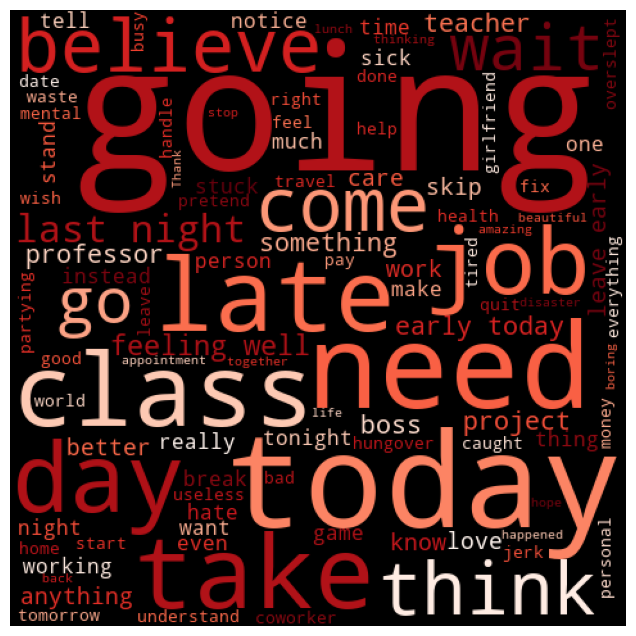

In [19]:
from wordcloud import WordCloud

cloud = WordCloud(max_words=100,width=480, height=480, background_color='black', colormap='Reds')
cloud.generate_from_text(pos_all)

# cloud = WordCloud(max_words=100,width=480, height=480, background_color='black', colormap='Greens')
# cloud.generate_from_text(neg_all)

plt.figure(figsize=(12,8), dpi=100)
plt.imshow(cloud)
plt.axis('off')

# plt.savefig('pos_sent_cloud.png', bbox_inches='tight', pad_inches=0, dpi=1000)
# plt.savefig('neg_sent_cloud.png', bbox_inches='tight', pad_inches=0, dpi=1000)
plt.show()


In [23]:
from collections import Counter

pos_frequencies = Counter(pos_all.split())

for word, freq in pos_frequencies.most_common(10):
    print("{}\t{}".format(word, freq))


I	114
to	80
I'm	59
going	35
a	35
this	25
the	24
can't	22
my	20
have	19


In [24]:
neg_frequencies = Counter(neg_all.split())

for word, freq in neg_frequencies.most_common(10):
    print("{}\t{}".format(word, freq))

to	92
the	71
I	66
you	62
a	41
Hi	36
for	36
wanted	35
I'm	25
be	25


In [29]:
# cleaning more
# nltk.download('omw-1.4')
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wn = WordNetLemmatizer()
sw = stopwords.words('english')

def process_text(x):
    x = x.lower()
    tokens = x.split()
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return " ".join(tokens)

train_df['processed_text'] = train_df.text.apply(process_text)
val_df['processed_text'] = val_df.text.apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanwhetten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ryanwhetten/nltk_data...


In [30]:
pos_frequencies_processed = Counter(process_text(pos_all).split())

for word, freq in pos_frequencies_processed.most_common(10):
    print("{}\t{}".format(word, freq))

going	35
need	14
take	10
late	10
believe	8
think	8
like	7
come	7
get	6
wait	6


In [31]:
neg_frequencies_processed = Counter(process_text(neg_all).split())

for word, freq in neg_frequencies_processed.most_common(10):
    print("{}\t{}".format(word, freq))

hi	36
wanted	35
good	26
professor	20
need	17
let	13
know	13
next	10
anything	9
morning	9


# Naive Bayes Classifier

[Scikit-Learn Description](https://scikit-learn.org/stable/modules/naive_bayes.html#:~:text=Naive%20Bayes%20methods%20are%20a,value%20of%20the%20class%20variable.)

*Bayes' Theorem:*

$P(y|x_1, ..., x_n) = \frac{P(y)P(x_1, ..., x_n|y)}{P(x_1, ..., x_n)}$ 


*The naive assumption (conditional independence)*

$P(x_i|y, x_1, ..., x_n) = P(x_i|y)$ 


*Plugging assumtion in*

$P(x_i|y, x_1, ..., x_n) \propto P(y)\Pi^{n}_{i=1}P(x_i|y)$ 




In [33]:
# first let's get p(y == 1)
# note mean of target is the same as (count of y==1) / (total count)

pos_prob = train_df['target'].mean() 
print('prob pos: ', pos_prob.round(3))

# now let's get p(y == 0)
# similarly use mean trick to calculate (count of y==0) / (total count)

neg_prob = (train_df['target'] == 0 ).mean()
print('prob neg: ', neg_prob.round(3))

# check for probabilit y distribution (should sum to 1)
pos_prob + neg_prob == 1

# expected output
# prob pos:  0.571
# prob neg:  0.429
# True

prob pos:  0.571
prob neg:  0.429


True

In [34]:
# now get P(x_i, y)
def prob_wgt(word, target):
  if target == 1:
    count = pos_frequencies[word]
    total = sum(pos_frequencies.values())
  if target == 0:
    count = neg_frequencies[word]
    total = sum(neg_frequencies.values())
  # smoothing
  if count == 0:
    count = 1e-5
  return count/total

# def prob_wgt(word, target):
#   if target == 1:
#     count = pos_frequencies_processed[word]
#     total = sum(pos_frequencies_processed.values())
#   if target == 0:
#     count = neg_frequencies_processed[word]
#     total = sum(neg_frequencies_processed.values())
#   if count == 0:
#     count = 1e-5
#   return count/total

In [35]:
prob_wgt('morning', 1)
# 0.0007062146892655367

0.0007062146892655367

In [36]:
prob_wgt('morning', 0)
# 0.0056568196103079825

0.0056568196103079825

Morning is more likely to come from class 0 than lass 1.

In [37]:
train_df.target.unique()

array([1, 0])

In [38]:
def predict_target(text):
  probs = {}
  for cat in [0,1]:
    # print(f'Class: {cat}')
    nll = 0
    for w in text.split():
      nll += -np.log(prob_wgt(w, cat))
      # print(f'word: {w}\t prob: {prob_wgt(w, cat):.5f}\t current nll: {nll:.2f}')
    probs[cat] = nll

  # print(probs)
  
  if (probs[0] - np.log(pos_prob)) < (probs[1] - np.log(pos_prob)):
    return 0  
  if probs[0] >= probs[1]:
    return 1 
  
  


In [39]:
predict_target("I hate you")

# Class: 0
# word: hate	 prob: 0.00000	 current nll: 18.89
# word: you	 prob: 0.03897	 current nll: 22.13
# Class: 1
# word: hate	 prob: 0.00212	 current nll: 6.16
# word: you	 prob: 0.01271	 current nll: 10.52
# 1

1

In [40]:
val_df.head()

,target,text,processed_text
0,1,I'm so mad at my partner right now. I can't be...,mad partner right believe
1,1,I'm going to fake being sick tomorrow so I can...,going fake sick tomorrow skip
2,1,I don't know how to tell my friend that I don'...,know tell friend want hang
3,1,I can't stand this professor. They have no ide...,stand idea teach
4,1,I'm going to cheat on this test. I need to pass.,going cheat need


In [41]:
train_df['nb_prediction'] = train_df.text.apply(predict_target)
val_df['nb_prediction'] = val_df.text.apply(predict_target)


In [42]:
print('train acc: ', (train_df.target == train_df.nb_prediction).mean().round(4))
print('val acc:   ', (val_df.target == val_df.nb_prediction).mean().round(4))

# train acc:  1.0
# val acc:    0.9565

train acc:  1.0
val acc:    0.9565


In [44]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(train_df.target, train_df.nb_prediction))


,0,1
0,76,0
1,0,101


In [45]:
pd.DataFrame(confusion_matrix(val_df.target, val_df.nb_prediction))

,0,1
0,20,0
1,2,24


In [46]:
val_df[val_df.target != val_df.nb_prediction][['text', 'target', 'nb_prediction']]


,text,target,nb_prediction
12,I hate my in-laws. They drive me crazy every t...,1,0
25,I'm going to talk badly about my friend to our...,1,0


In [47]:
val_df[val_df.target != val_df.nb_prediction].text[25]


"I'm going to talk badly about my friend to our mutual friends. They need to know the truth."

In [58]:
predict_target("I'm going to the gym")

1

## TF-IDF w/Random Forest

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(train_df.text)
# X = vectorizer.fit_transform(train_df.processed_text)
X

<177x459 sparse matrix of type '<class 'numpy.float64'>'
	with 1293 stored elements in Compressed Sparse Row format>

In [116]:
X_tfidf_val = vectorizer.transform(val_df.text)

In [117]:
# visualize TF-IDF with PCA
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
components = pca.fit_transform(X.toarray())
components.shape

(177, 3)

In [118]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=train_df["target"].astype(str),
    hover_name=train_df["text"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [119]:
fig = px.scatter_3d(pd.DataFrame(components), 
                    x=0, y=1, z=2, 
                    color=train_df["target"].astype(str),
                    hover_name=train_df["text"]
)
fig.show()

In [73]:
rf = RandomForestClassifier(max_depth=10, n_estimators=7, n_jobs=-1)
rf.fit(X, train_df.target)

y_pred_train = rf.predict(X)
print('Train accuracy: ', (train_df.target == y_pred_train).mean().round(3))

y_pred_val = rf.predict(X_tfidf_val)
print('Validation accuracy: ', (val_df.target == y_pred_val).mean().round(3))

Train accuracy:  0.966
Validation accuracy:  0.913


In [74]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

top_word_indicies = []
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    top_word_indicies.append(indices[f])

print("\n")


# Print top features   
for ind in top_word_indicies:
    print(vectorizer.get_feature_names()[ind])

Feature ranking:
1. feature 175 (0.164085)
2. feature 437 (0.102590)
3. feature 215 (0.066480)
4. feature 300 (0.043398)
5. feature 132 (0.041178)
6. feature 414 (0.039718)
7. feature 154 (0.031463)
8. feature 227 (0.029563)
9. feature 168 (0.022290)
10. feature 8 (0.022071)


hi
wanted
let
professor
feedback
trouble
good
make
having
afternoon


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [36]:
# pos_frequencies['Hi']
# neg_frequencies['Hi']

## Sentence Embedding

In [88]:
from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/opt/anaconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning:

`cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`



In [89]:
train_df.head()

,target,text,processed_text,nb_prediction
0,1,I can't stand working for this jerk. I'm so do...,stand working done,1
1,1,I don't know how we're going to get this proje...,know going get project team,1
2,1,I'm so bored. Can't wait to get out of here an...,wait get go,1
3,1,I'm calling in sick tomorrow. I can't handle a...,calling sick handle another day,1
4,1,I just got offered a job with better pay and b...,got offered job better pay take,1


In [90]:
embeddings_train = minilm.encode(train_df.text, convert_to_tensor=True)

In [91]:
embeddings_val = minilm.encode(val_df.text, convert_to_tensor=True)

In [92]:
embeddings_train.shape

torch.Size([177, 384])

In [93]:
# visualize embeddings with PCA
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
components = pca.fit_transform(embeddings_train)
components.shape

(177, 3)

In [96]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=train_df["target"].astype(str),
    hover_name=train_df["text"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [97]:
fig = px.scatter_3d(pd.DataFrame(components), 
                    x=0, y=1, z=2, 
                    color=train_df["target"].astype(str),
                    hover_name=train_df["text"]
)
fig.show()

In [98]:
rf_emb = RandomForestClassifier(max_depth=10, n_estimators=7, n_jobs=-1)
rf_emb.fit(embeddings_train.cpu().numpy(), train_df.target)

y_pred_train = rf_emb.predict(embeddings_train)
print('Train accuracy: ', (train_df.target == y_pred_train).mean().round(3))

y_pred_val = rf_emb.predict(embeddings_val)
print('Validation accuracy: ', (val_df.target == y_pred_val).mean().round(3))

Train accuracy:  0.994
Validation accuracy:  0.913


In [99]:
test_y = minilm.encode("Hi I'm running into some issues. I hate you", convert_to_tensor=True)
# test_y = minilm.encode("Hi I'm running into some issues.", convert_to_tensor=True)

In [101]:
rf_emb.predict(test_y.reshape(1, -1))
# test_y.reshape(-1, 1)

array([1])

In [108]:
neg_sents[:7]

["Hi just wanted to let you know that I finished the project and it's ready for your review. Let me know if you need anything else from me.",
 "Good morning I'm running a few minutes late today due to traffic. I should be in the office by",
 "Hi I'm having trouble accessing the company database. Are you available to help troubleshoot the issue?",
 'Just a reminder that we have a team meeting attoday. Looking forward to seeing you there.',
 "Hi I need to take a personal day tomorrow. I've already notified and I will make sure to complete any outstanding tasks before I leave.",
 "Thanks for your feedback on the report. I've made the changes you suggested and will send the updated version to you shortly.",
 "Can we schedule a quick call to discuss the new project? I have some ideas I'd like to run by you."]

In [109]:
test_y = minilm.encode(neg_sents[:3], convert_to_tensor=True)


In [110]:
rf_emb.predict(test_y)


array([0, 0, 0])